<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Johnny Godoy


### **Link de repositorio de GitHub:** `https://github.com/johnny-godoy/laboratorios-mds/blob/main/2023/lab10/laboratorio_10.ipynb`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [24]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import HTML, display
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

In [25]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
    import shap
    import ydata_profiling
    from alibi.explainers import AnchorTabular

In [26]:
df = pd.read_csv("data/input/diabetes_data.csv").drop_duplicates()
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64020 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   64020 non-null  float64
 1   Sex                   64020 non-null  float64
 2   HighChol              64020 non-null  float64
 3   CholCheck             64020 non-null  float64
 4   BMI                   64020 non-null  float64
 5   Smoker                64020 non-null  float64
 6   HeartDiseaseorAttack  64020 non-null  float64
 7   PhysActivity          64020 non-null  float64
 8   Fruits                64020 non-null  float64
 9   Veggies               64020 non-null  float64
 10  HvyAlcoholConsump     64020 non-null  float64
 11  GenHlth               64020 non-null  float64
 12  MentHlth              64020 non-null  float64
 13  PhysHlth              64020 non-null  float64
 14  DiffWalk              64020 non-null  float64
 15  Stroke             

In [28]:
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000,64020.000000
mean,8.607420,0.455983,0.539550,0.973211,30.178554,0.490706,0.159950,0.678366,0.590862,0.771587,0.046345,2.921103,4.130537,6.385020,0.277007,0.068510,0.581756,0.521681
std,2.860717,0.498063,0.498437,0.161466,7.287730,0.499918,0.366563,0.467107,0.491679,0.419813,0.210233,1.107991,8.466301,10.368493,0.447524,0.252621,0.493275,0.499534
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,11.000000,1.000000,1.000000,1.000000,34.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,7.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


No hay valores faltantes. Los atributos categóricos ya están codificados
numéricamente. Solamente hay jóvenes. Varios atributos son
discretos-ordinales o binarios, lo que sirve para modelos de árboles. El problema
está bien balanceado.

In [57]:
filename = "output/report.html"
if not os.path.exists(filename):
    profile = ydata_profiling.ProfileReport(df, title="EDA")
    profile.to_file(filename)
display(HTML(filename=filename))

Number of variables,18
Number of observations,64020
Missing cells,0
Missing cells (%),0.0%
Duplicate rows,0
Duplicate rows (%),0.0%
Total size in memory,11.3 MiB
Average record size in memory,185.0 B
Numeric,4
Categorical,14
CholCheck is highly imbalanced (82.2%),Imbalance


Cabe destacar que el `BMI` debe ser un atributo porcentual (normalizado al rango
0-100 en algún conjunto de datos), pues pocas personas en la
 historia han tenido valor cercano a 100. Si fuera `BMI` real la mayoría del conjunto
  de datos tendría obesidad mórbida.

## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

In [29]:
X = df.drop(columns=["Diabetes"])
y = df["Diabetes"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=0,
    stratify=y,
    test_size=0.2,
)

Notamos que todas las variables son numéricas y no hay valores faltantes, por lo que
bastará utilizar `XGBoost` sin un `Pipeline` o `ColumnTransformer`. Se realizará
`GridSearchCV` con 5 folds, y se medirá el _f1 score_ para seleccionar el mejor
modelo. En pruebas con `optuna`, no se logró encontrar mejores hiperparámetros que
los por defecto, por lo que solamente se probará con un rango pequeño de valores
cercanos a los por defecto.

_f1 score_ se escoge debido a que es una medida robusta que balancea la
 precisión y el _recall_ sin tener que pensar mucho más profundamente
en la decisión. Podremos interpretar esta medida como un error total de clasificación.

Para validar el modelo, se verá la matriz de confusión.


In [30]:
gridsearch_root = "output/gridsearch.pkl"
try:
    with open(gridsearch_root, "rb") as f:
        grid = pickle.load(f)
except FileNotFoundError:
    base_clf = xgb.XGBClassifier(random_state=0, n_jobs=5)
    param_grid = {
        "n_estimators": [100, 150, 200],
        "max_depth": [5, 6, 7],
        "learning_rate": [0.15, 0.3, 0.6],
    }
    grid = GridSearchCV(
        base_clf,
        param_grid,
        scoring="f1",
    )
    grid.fit(X_train, y_train)
    with open(gridsearch_root, "wb") as f:
        pickle.dump(grid, f)

Puntajes en validación:

In [31]:
index = grid.best_index_
pd.DataFrame(grid.cv_results_).loc[index]

mean_fit_time                                                              1.027432
std_fit_time                                                                0.19584
mean_score_time                                                            0.015004
std_score_time                                                             0.002098
param_learning_rate                                                            0.15
param_max_depth                                                                   5
param_n_estimators                                                              100
params                 {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}
split0_test_score                                                          0.765355
split1_test_score                                                          0.753739
split2_test_score                                                          0.767167
split3_test_score                                                          0

Vemos que el `f1-score` no es tan alto para lo que queremos (0.76 en promedio), pero
es muy estable (0.004 de desviación estándar). Esto indica que el modelo no está
 sobreajustando a cada _fold_.

Nos interesa más aún saber si este puntaje generaliza bien a datos de prueba, y saber
 si el modelo está sesgado hacia alguna clase:

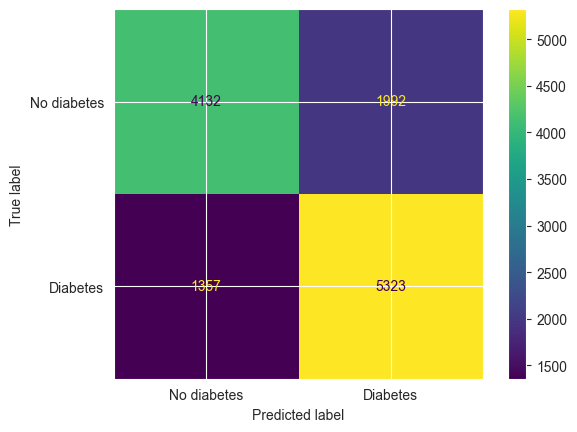

In [32]:
clf = grid.best_estimator_
conf = confusion_matrix(y_test, clf.predict(X_test))
disp = ConfusionMatrixDisplay(conf, display_labels=["No diabetes", "Diabetes"])
disp.plot();

Tanto en los conjuntos validación como en el de prueba, el modelo se equivoca cerca
de 1/4 de las veces en cualquiera de las dos clases. Esto muestra que el modelo no
está sesgado hacia ninguna clase, y que la validación es representativa del error de
generalización en el conjunto de prueba.

El error sí es más alto de lo deseado dado la importancia del problema, pero no se
logró encontrar una mejora simple de implementar.


Con esto, respondemos las preguntas:

* ¿Es acaso un buen predictor de diabetes? R: Muestra un buen puntaje de
clasificación al realizar validación cruzada, pero ésto es solamente un proxy del
error de generalización verdadero. En realidad, no sabemos si los datos
proporcionados son suficientemente representativos de la población de pacientes, y no
 se realizó un EDA para validar que éstos datos permitan una capacidad de generalizar
  para pacientes reales.
* ¿Qué buscan explicar las métricas utilizadas? R: Que el modelo sea capaz de
 clasificar correctamente a los pacientes fuera de la muestra de entrenamiento (pero
 dentro del conjunto de prueba).
* ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su
modelo una buena elección de las features? R: No, solamente determinan que el modelo
es preciso, pero `XGBoost` no realiza una selección de características, y puede
ajustarse al ruido específico de este conjunto de datos. Debido a que utiliza
mecanismos como _column subsampling_, el modelo
puede terminar utilizando características inútiles, y estará sesgado hacia utilizar
más frecuentemente características repetidas.

## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

 Se crea cada uno de los gráficos de importancia de características.

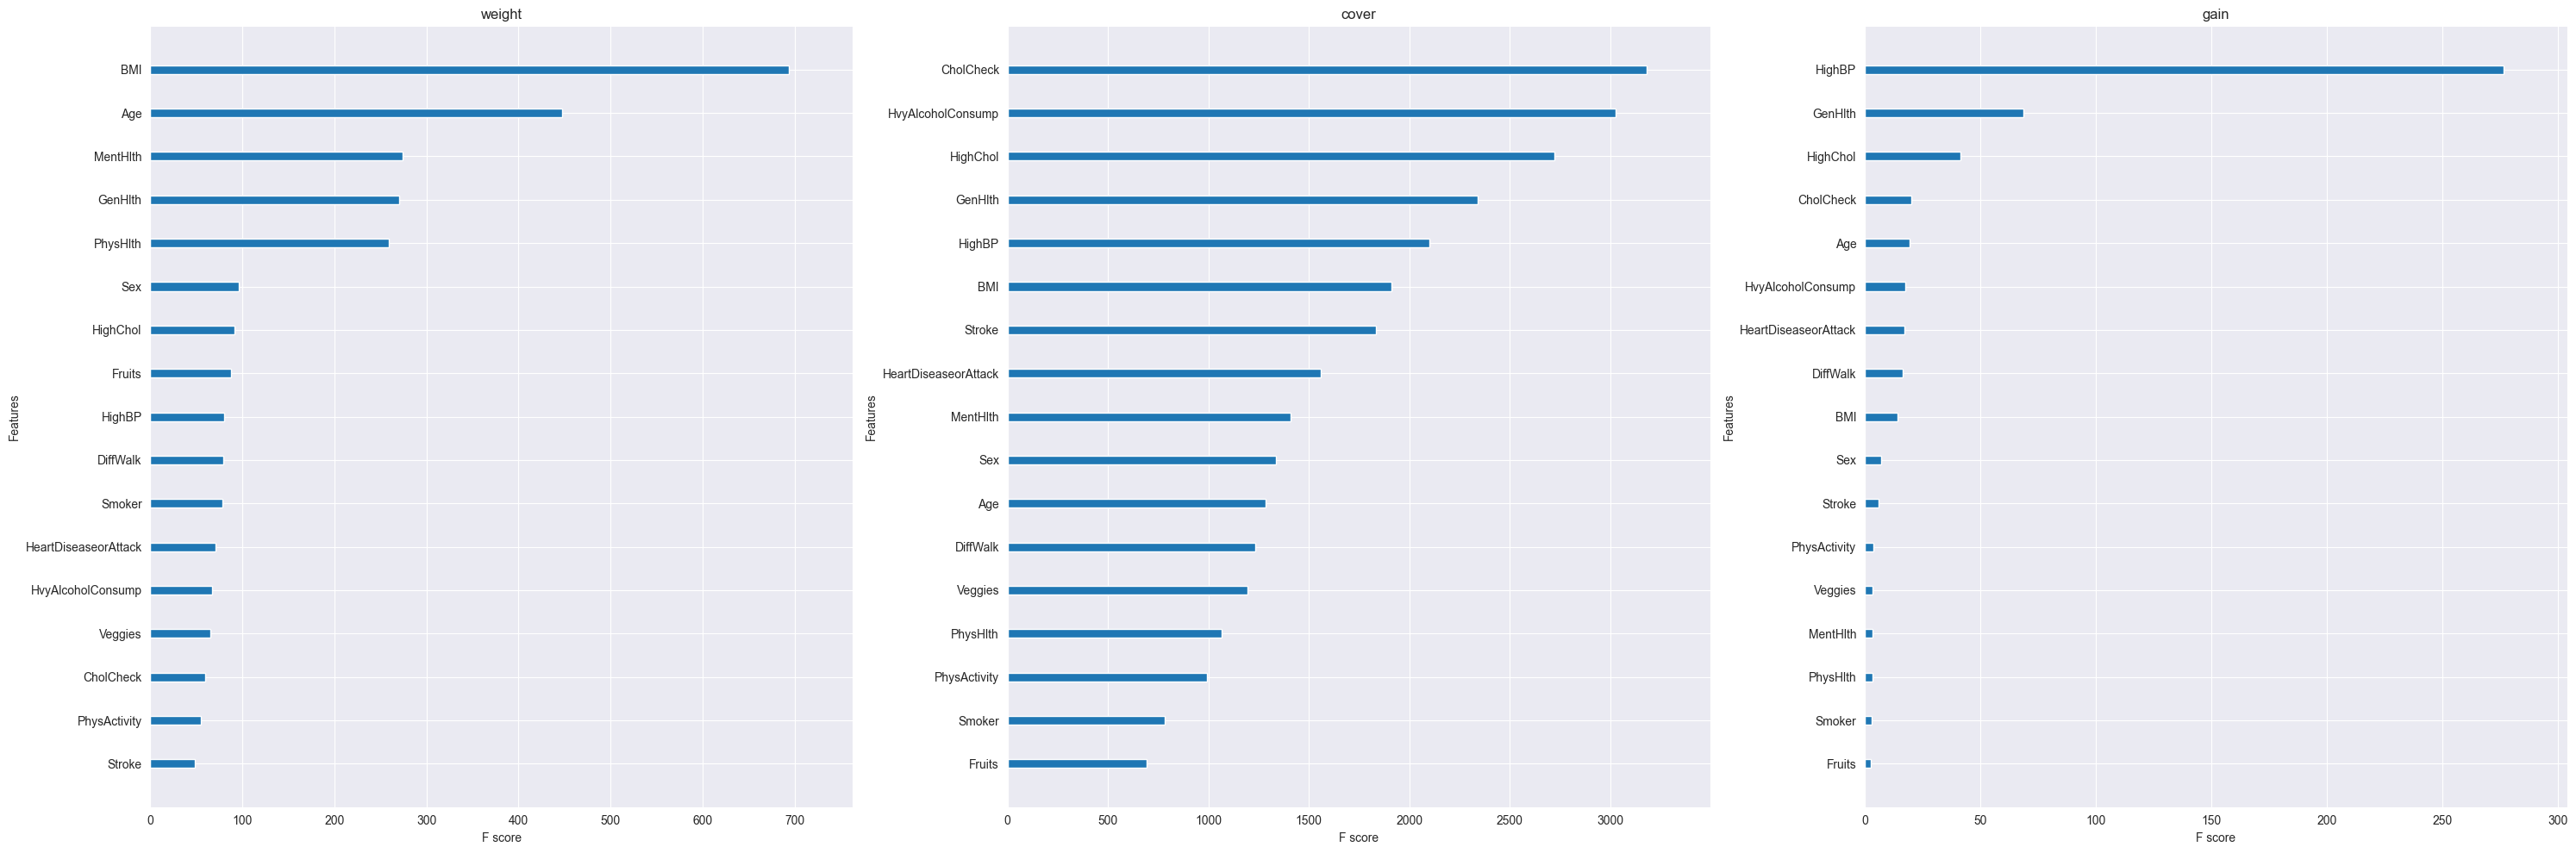

In [33]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
importance_types = ("weight", "cover", "gain")
for method, ax in zip(importance_types, axes):
    xgb.plot_importance(
        clf, importance_type=method, title=method, ax=ax, show_values=False
    )
plt.tight_layout()

Para responder respecto a la consistencia, se creará un gráfico que compare la
posición de ranking de cada característica en cada método, conectando con una línea
las posiciónes de cada característica en cada método. Líneas horizontales indicarían
que ambos métodos coinciden en ranking, pero estas no se dibujarán por claridad. Es
decir, la presencia de una línea en el gráfico indica un desacuerdo en el ranking de
distintos métodos. Líneas más largas indican un mayor desacuerdo.

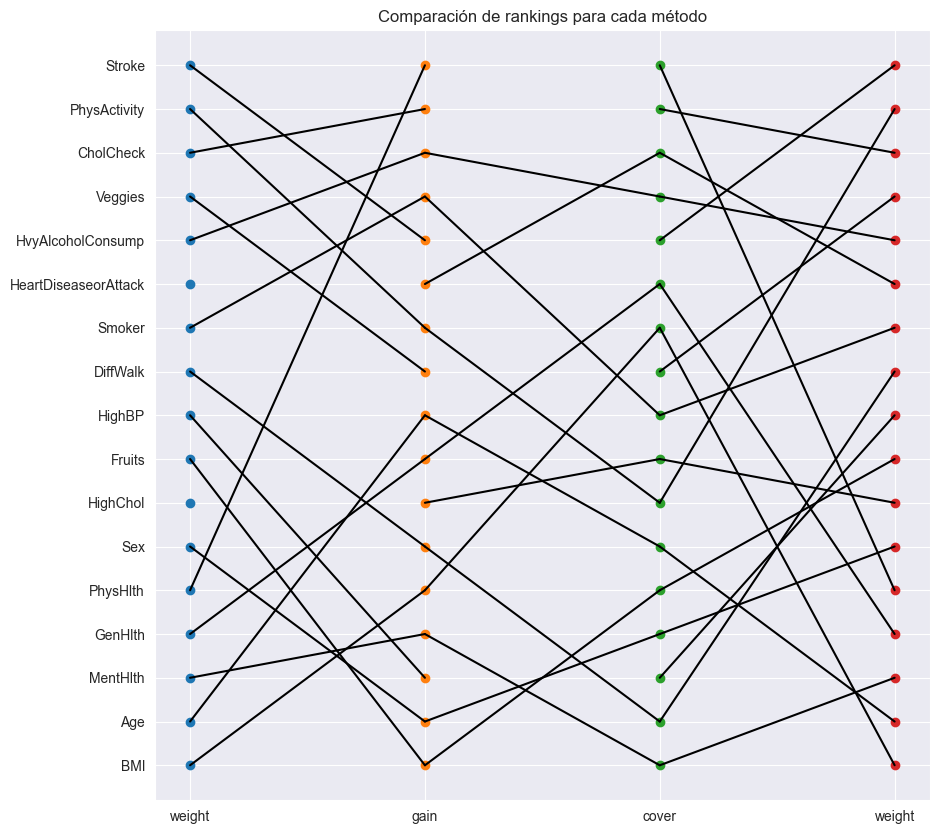

In [34]:
booster = clf.get_booster()
importances = {
    method: pd.Series(booster.get_score(importance_type=method))
    .sort_values(ascending=False)
    .index
    for method in importance_types
}
weight = importances["weight"]
x = np.zeros_like(weight, dtype=np.float32)
ns = np.arange(len(weight))
fig, ax = plt.subplots(figsize=(10, 10))
for i, method in enumerate(importance_types):
    ax.scatter(x + i, ns, marker="o")
ax.scatter(x + len(importance_types), ns, marker="o")

weight_indices = np.arange(len(weight))
gain_indices = importances["gain"].values.argsort()
cover_indices = importances["cover"].values.argsort()

weight_gain_mask = weight_indices != gain_indices
gain_cover_mask = gain_indices != cover_indices
cover_weight_mask = cover_indices != weight_indices

ax.plot(
    [0, 1],
    np.column_stack((weight_indices, gain_indices))[weight_gain_mask].T,
    color="k",
)
ax.plot(
    [1, 2], np.column_stack((gain_indices, cover_indices))[gain_cover_mask].T, color="k"
)
ax.plot(
    [2, 3],
    np.column_stack((cover_indices, weight_indices))[cover_weight_mask].T,
    color="k",
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax.set_yticklabels(weight)
    ax.set_yticks(ns)
    ax.set_xticklabels(["weight", "gain", "cover", "weight"])
    ax.set_xticks([0, 1, 2, 3])
ax.set_title("Comparación de rankings para cada método");

Se puede observar muchas líneas, y líneas con gran pendiente, indicando que los
rankings son muy inconsistentes.

Este desacuerdo se explica porque cada importancia mide algo distinto. Según la
documentación de `XGBoost`:

* ”weight” is the number of times a feature appears in a tree

* ”gain” is the average gain of splits which use the feature

* ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

Que no necesariamente coinciden, pero las tres están relacionadas por como los
árboles utilizan la característica para realizar las particiones. Esto significa que
existe un sesgo por características que tienen más valores únicos, pues hay más
chances para dividirse.

Sin embargo, sí hay algunos acuerdos generales:
* `CholCheck` siempre es una de las características más importantes (sus puntos están
 arriba en el gráfico)
* `MentlHlth` siempre es una de las características menos importantes (sus puntos
 están abajo en el gráfico)
* `PhysHlth` y `Stroke` tienen mucha variabilidad en los ranking (líneas largas)


Para responder las otras preguntas planteadas:

* ¿Las importancias obtenidas son suficientes para obtener la interpretabilidad de un
 modelo que utiliza árboles? R: No, solamente tenemos una indicación global (y
 sesgada) de la importancia de cada característica, pero no podemos reconstruir cómo
 el modelo toma las decisiones, cómo se puede para un árbol de decisión, que se puede
  graficar de una manera que permite interpretabilidad global (viendo la estrcutura
  del árbol) y local (siguiendo un camino hacia una hoja), ambas exactas.
* ¿Qué debilidad presenta este método? R: La interpretación es inexacta, sesgada.
  No indica signos, es decir, si una característica aumenta o disminuye la
  probabilidad de diabetes. Esconde la relacíón con la distribución de cada variable
  (en particular, valores únicos). No permite reconstruir el modelo.

In [35]:
scores = []
for i in range(1, 50):
    tree = DecisionTreeClassifier(max_depth=i, random_state=0)
    tree.fit(X_train, y_train)
    scores.append(tree.score(X_test, y_test))
best_depth = np.argmax(scores) + 1

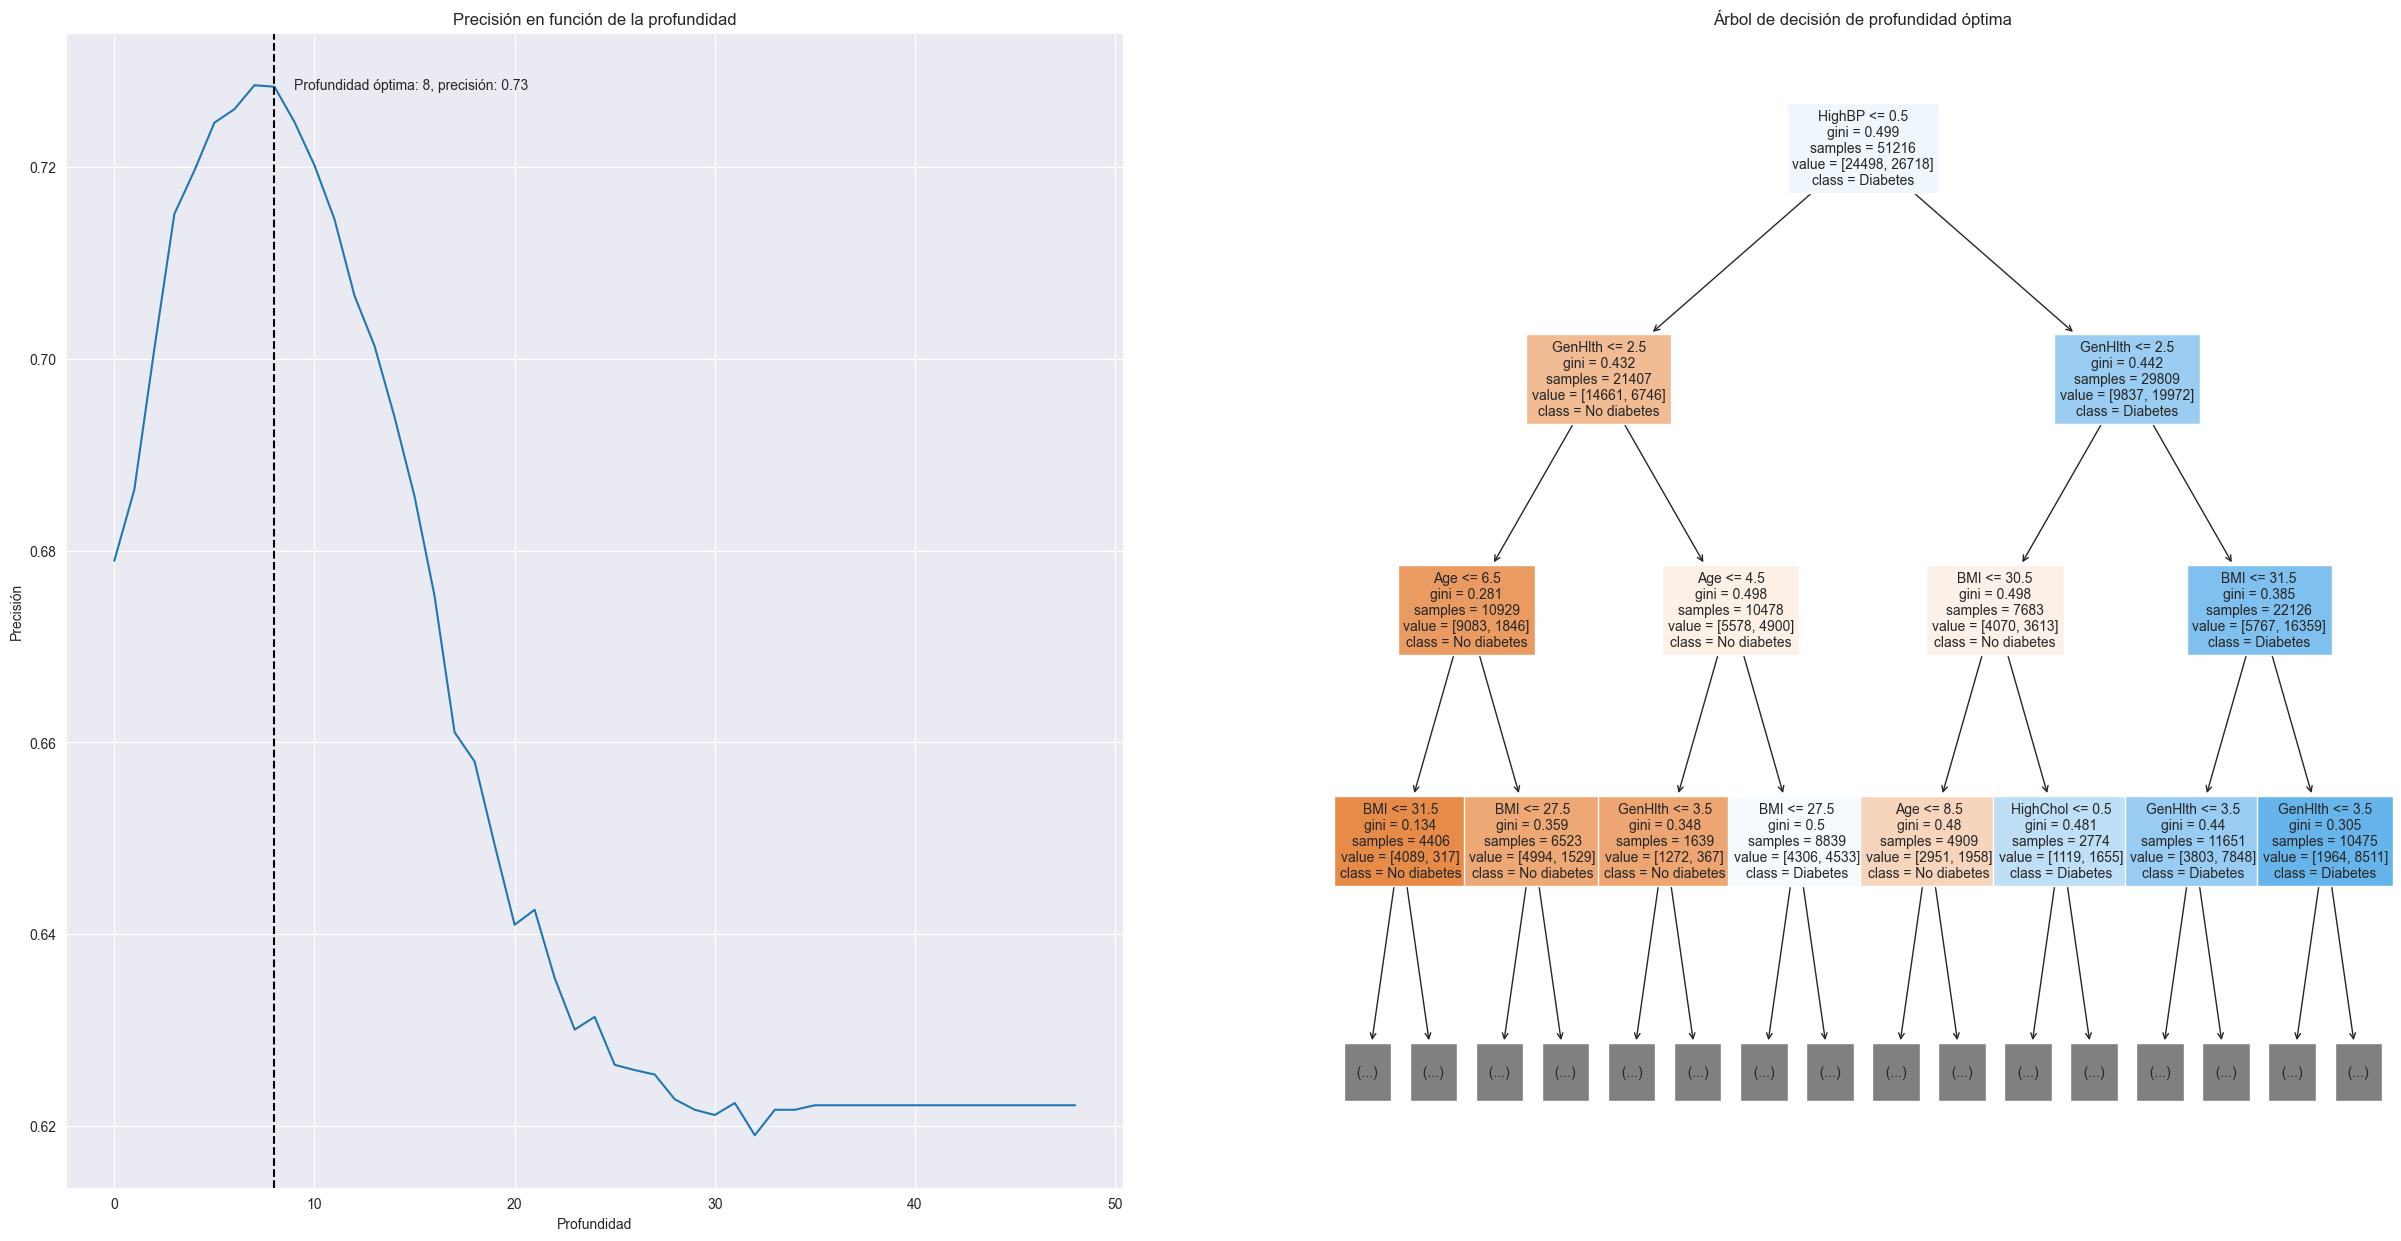

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 15))
ax[0].plot(scores)
ax[0].set_title("Precisión en función de la profundidad")
ax[0].set_xlabel("Profundidad")
ax[0].set_ylabel("Precisión")
ax[0].axvline(best_depth, color="k", linestyle="--")
ax[0].text(
    best_depth + 1,
    scores[best_depth - 1],
    f"Profundidad óptima: {best_depth}, precisión: {scores[best_depth - 1]:.2f}",
    va="center",
    ha="left",
)
tree = DecisionTreeClassifier(max_depth=best_depth, random_state=0)
tree.fit(X_train, y_train)
plot_tree(
    tree,
    max_depth=3,  # Tamaño más pequeño para que se vea bien
    ax=ax[1],
    feature_names=X.columns,
    filled=True,
    fontsize=10,
    class_names=["No diabetes", "Diabetes"],
)
ax[1].set_title("Árbol de decisión de profundidad óptima");

## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

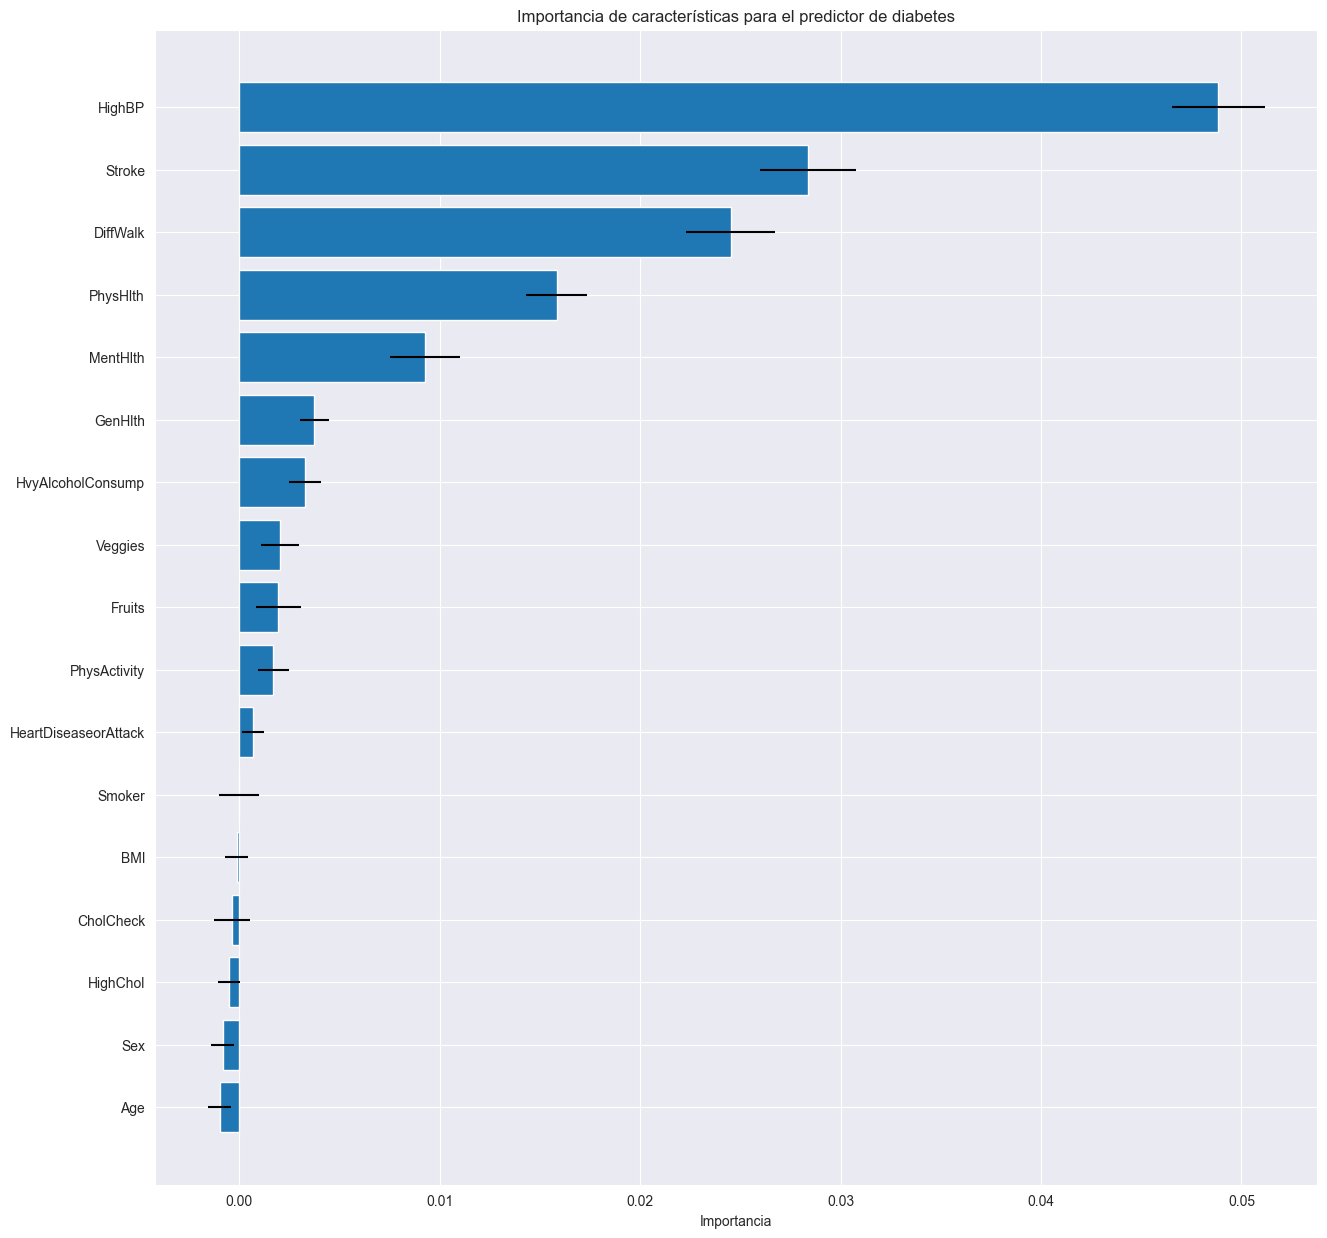

In [37]:
perm_importance = permutation_importance(
    clf, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1
)
perm_importance_df = pd.DataFrame(
    {
        "importances_mean": perm_importance.importances_mean,
        "importances_std": perm_importance.importances_std,
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=True)
plt.figure(figsize=(15, 15))
plt.barh(
    range(X.shape[1]),
    perm_importance_df.importances_mean,
    xerr=perm_importance_df.importances_std,
)
plt.yticks(range(X.shape[1]), X.columns)
plt.title("Importancia de características para el predictor de diabetes")
plt.xlabel("Importancia");

Respondiendo lo pedido:

* La desviación estándar indica la variabilidad de los resultados, pues la
permutación es aleatoria. Si bien se espera que en principio las permutaciones deben
empeorar los resultados, por la aleatoriedad puede haber casos en que mejoren. En
este caso, la mayoría de importancias tiene una desviación estándar baja, lo que
muestra que el método es consistente.
* La importancia de una característica se mide como la pérdida de
puntaje que incurre el modelo al permutar los valores de una característica.
* Las 5 características de mayor impacto al modelo son:
    * `HighBP` (presión sangínea alta)
    * `Stroke` (si tuvo un ataque cerebrovascular)
    * `DiffWalk` (dificultad para caminar)
    * `PhysHealth` (puntaje de salud física)
    * `MentHealth` (puntaje de salud mental)
* Todas éstas tienen que ver con la salud, y tiene sentido que se correlacionen con
la diabetes. Es importante destacar que no necesariamente implican una relación
causal. Consultando con un médico, se verificó que si bien se conoce de la relación
entre los ataques cerebrovasculares y la diabetes, no se ha determinado una
causalidad desde la fisiopatología. El único caso donde se puede afirmar que hay una
relación causal es en la dificultad para caminar, pues esta causa sedentarismo.
* Existen dos diferencias muy grandes a las importancias anteriores: `CholCheck` se
considera dañino para el modelo (importancia negativa), y `MentlHlth` se considera
muy buen predictor. Esto no es explicado por la cantidad de valores únicos que tiene
cada variable, pues `CholCheck` tiene 2 y `MentlHlth` tiene 31 valores. Sin embargo,
sí se puede explicar porque ahora las interacciones sí se toman en cuenta.
* Ventajas: Este modelo toma en cuenta interacciones. Logra una mejor interpretación
global en términos del error del modelo, sin requerir reentrenamiento. Más aún, es
agnóstico y comparable entre modelos.
* Desventajas: El error está enlazado al error del modelo. Caracerísticas
correlacionadas pueden causar sesgos, pues las permutaciones no deberían ser
independientes para generar datos de la distribución original. Como la importancia se
 divide en todas las características correlacionadas, si hay varias entonces se
 diluye la importancia de cada una.

In [38]:
X.nunique().sort_values(ascending=False)

BMI                     80
PhysHlth                31
MentHlth                31
Age                     13
GenHlth                  5
Veggies                  2
Stroke                   2
DiffWalk                 2
HvyAlcoholConsump        2
Fruits                   2
Sex                      2
PhysActivity             2
HeartDiseaseorAttack     2
Smoker                   2
CholCheck                2
HighChol                 2
HighBP                   2
dtype: int64

## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Se calcularon los valores de SHAP para todo el dataset en vez de solamente el
conjunto de entrenamiento como se vé en algunos ejemplos. Esto de debido a que
después se pide explicar instancias específicas que podrían formar parte de
cualquiera de los dos conjuntos dependiendo de como se dividieron los datos.


Acá un signo positivo significa que aumentos en la característica aumentan la
probabilidad de tener diabetes, mientras que un signo negativo significa que aumentos
 en la característica disminuyen la probabilidad de tener diabetes. En general, una
 variable tendrá tanto valores positivos como negativos, pues el modelo no es lineal.
  Esto significa que para algunos pacientes una característica puede implicar un
  aumento de probabilidad de diabetes, mientras que para otros pacientes este mismo
  valor implica una disminución.

In [39]:
explainer = shap.TreeExplainer(clf)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(X)
pd.DataFrame(shap_values, columns=X.columns, index=X.index).head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP
0,-1.026560,0.008977,-0.439114,0.029464,-0.342847,0.008693,-0.061154,0.004153,0.000423,-0.024877,0.029179,0.054244,-0.184836,0.092628,-0.089071,-0.022545,0.428644
1,0.245925,0.064547,0.163573,0.017317,-0.293388,-0.032035,-0.044783,0.073778,0.026808,0.069421,0.041073,0.084423,0.020633,0.005599,-0.064335,0.114233,0.347924
2,0.792307,0.219198,-0.151763,0.030192,-0.291248,-0.007490,-0.037095,-0.032856,-0.026772,-0.021163,0.047696,-0.887070,0.048786,0.100116,-0.087138,-0.019266,-0.563719
3,0.320420,0.077391,0.186606,0.024601,-0.149637,-0.011896,-0.036314,-0.029691,-0.017971,-0.028286,0.039637,0.077160,0.011180,-0.009014,-0.090873,-0.007912,0.307017
4,-0.045402,-0.080013,-0.232086,0.030714,0.104037,-0.003471,-0.048577,-0.004121,0.006378,-0.017323,0.043292,-0.546284,0.084615,0.044429,-0.035780,-0.017352,-0.530409


### Parte B (0.4 pt)

Se grafica el aporte para las instancias 1, 9 y 50, para responder cada pregunta.

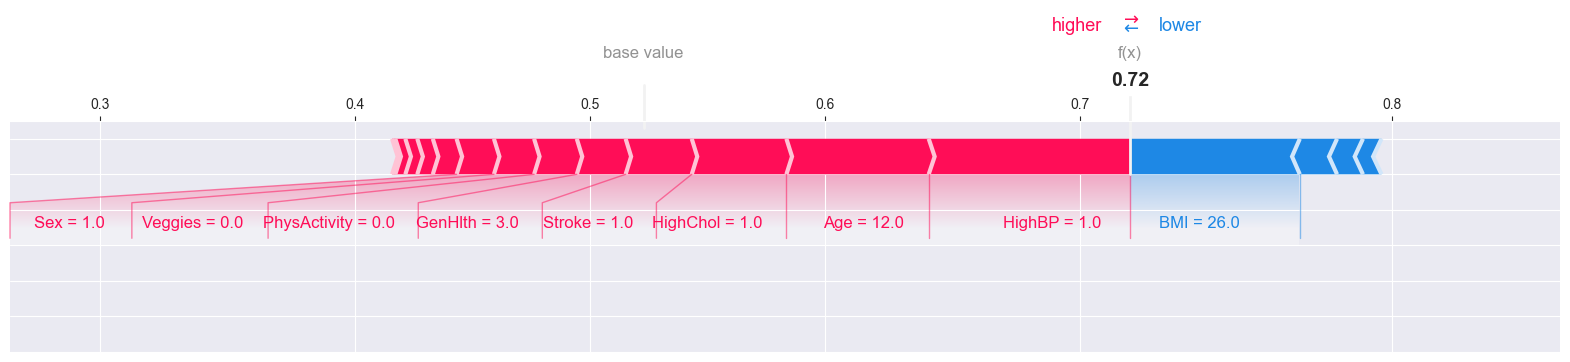

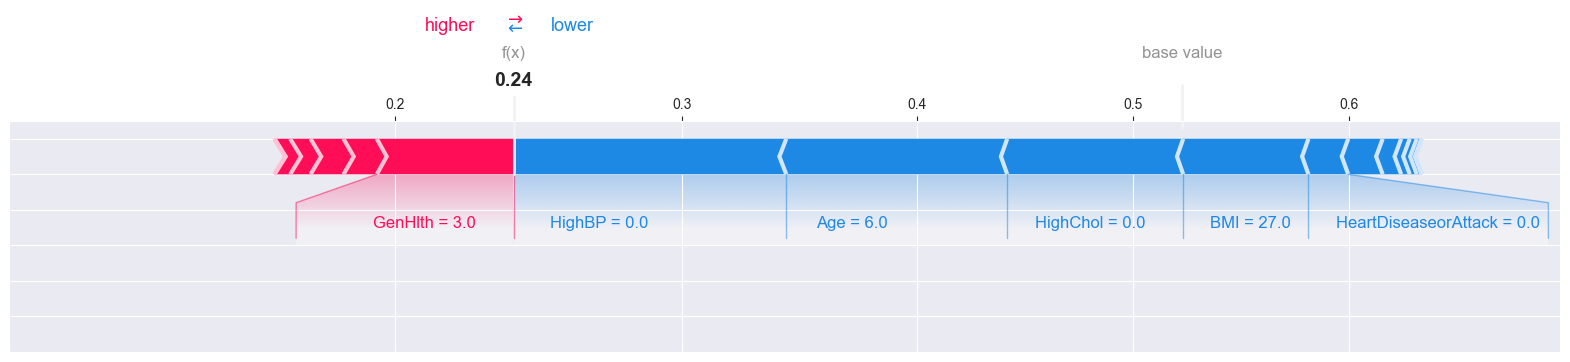

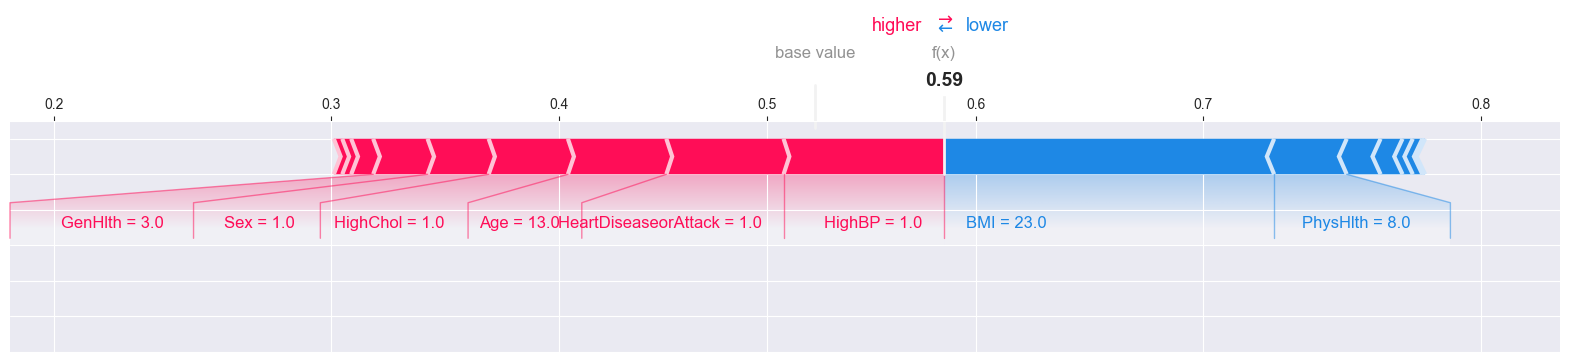

In [40]:
indice_instancias = [1, 9, 150]
instancias = X.iloc[indice_instancias, :]
valores = shap_values[indice_instancias, :]
for instancia, valor in zip(instancias.iterrows(), valores):
    shap.force_plot(
        explainer.expected_value,
        valor,
        instancia[1],
        matplotlib=True,
        link="logit",
    )

- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? R: Ignorando los efectos muy pequeños para ser significativos, vemos cada instancia por separado
    - Instancia 1:
        - Aumento de probabilidad: Por haber tenido un ataque cerebrovascular, alto colesterol y alto presión sanguínea. También contribuye la falta de vegetales y actividad física. Otros factores de aumento es tener 12 años, salud general 3, y pertenecer al sexo 1.
        - Disminución: Por tener un BMI de 26
    - Instancia 3:
        - Aumento: Salud general 3.
        - Disminución: Por no tener alta presión sanguínea, alto colesterol, ataque/enfermedad de corazón. También por tener 6 años y un BMI de 27.
    - Instancia 50:
        - Aumento: Por haber tenido alta presión sanguínea y ataque/enfermedad de corazón. También por tener 13 años, salud general 3 y pertenecer al sexo 1.
        - Disminución: Por tener salud física 8 y BMI de 23.
- ¿Existe algún patrón común entre las instancias analizadas? R: Existen varios patrones comunes que ocurren en los 3 instancias:
    - Tener alta presión sanguínea aumenta la probabilidad de diabetes, y no tenerla disminuye la probabilidad considerablemente.
    - En los 3 casos se tenía una salud general 3, lo que aumentaba las probabilidades de diabetes.
    - Tener 12/13 años aumenta la probabilidad, pero tener 6 la disminuye.
    - El BMI es cercano (~25) y siempre disminuye la probabilidad.

    También se detecta que puedan haber otros patrones más débiles (son un efecto fuerte para 2 instancias, pero no para las 3):
    - Pertenecer al sexo 1 causa aumento de probabilidad considerable
    - Alto colesterol aumenta la probabilidad, no tener alto colesterol la disminuye
    - Tener un ataque/enfermedad cardíaca aumenta la probabilidad, no tenerla la disminuye
    En general, no se vió que dos instancias muestren un efecto contradictorio para cada variable (en términos de signos distintos), pero sí de magnitudes distintas (modelando no-linealidad).
- ¿Es posible generalizar estas conclusiones a todo el dataset? R: No, la interpretación que proveen los SHAP values es una local, que solamente afecta a las predicciones vistas.

### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

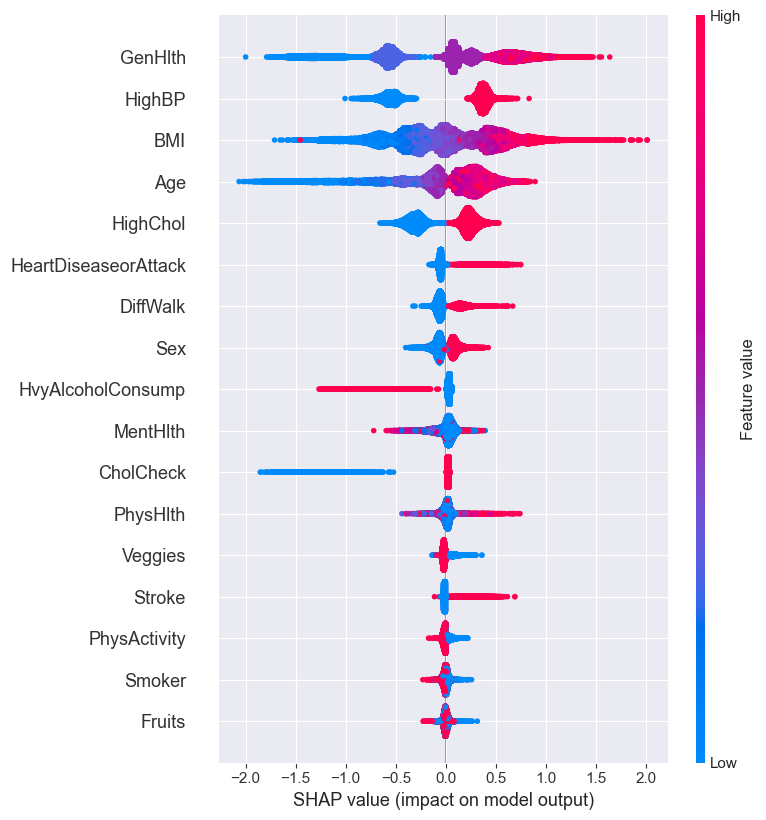

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap.summary_plot(shap_values, X)

* En varias variables binarias (`HighBP`, `HighCol`, `HeartDiseaseOrAttack`, `DiffWalk`, `Sex`, `CholCheck`, `HvyAlcholConsump`, `PhysActivity`) se vén dos agrupaciones de valores, una positiva y otra negativa, mostrando que el signo del efecto es independiente de otras variables. Tiene sentido esperar que en todos los pacientes con alta presión sanguínea haya un aumento de probabilidad de diabetes (y viceversa), pero esto puede combinarse con otros factores de forma no lineal. En el caso de `CholCheck` hay mucha mayor variabilidad para aquellos con valor 0, con distintas magnitudes de disminución de probabilidad, pero cuando tienen valor 1, es un aumento ligero.
* Las 6 variables inferiores en el gráfico no parecen ser muy importantes: Las magnitudes de sus valores de SHAP son pequeñas y tienen efectos confusos (valores similares tienen impactos con signo distinto).
* La relación de los valores de SHAP con el valor de `GenHealth` no es monótona. Sin entender la distribución de la variable, cuesta determinar si coincide con la interpretación local.
* Vemos que se siguen patrones de la pregunta anterior, como que menor edad implica menor valor de SHAP, que sexo 1 implica uno mayor.
* No hay diferencias mayores con la interpretación local que se puedan detectar solamente a partir del gráfico. Se nota que el valor de `Veggies` es poco relevante en general (y tiene una relación no monótona discontinua extraña), pero fue importante para una de las instancias estudiadas. 

### Parte D (0.4 pt)

In [42]:
def shap_to_probability(shap_value: np.ndarray) -> np.ndarray:
    """Convierte un valor de SHAP a una probabilidad."""
    odd_shift = np.exp(shap_value)
    return odd_shift / (1 + odd_shift)

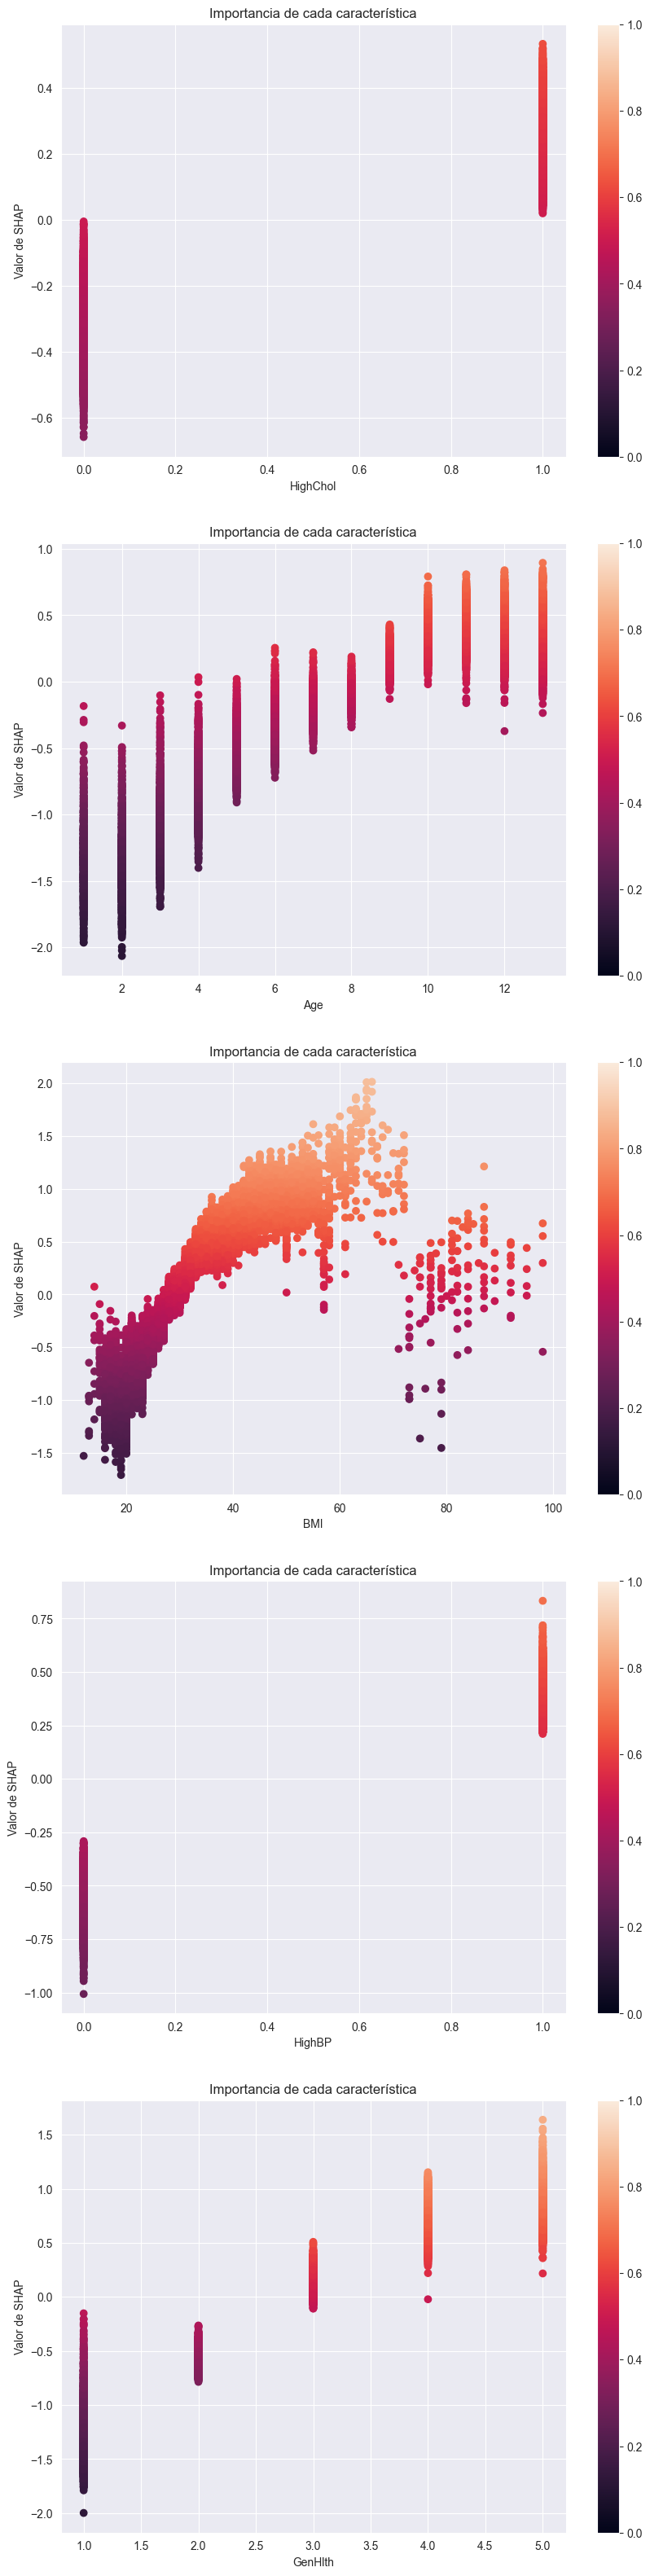

In [43]:
top = 5
indexes = np.argsort(np.abs(shap_values).mean(0))[-top:]
fig, axes = plt.subplots(nrows=top, figsize=(10, 8 * top))
for ax, feature in zip(axes, indexes):
    shap_x = shap_values[:, feature]
    scatter = ax.scatter(
        X.iloc[:, feature], shap_x, c=shap_to_probability(shap_x), vmin=0.0, vmax=1.0
    )
    ax.set_xlabel(X.columns[feature])
    ax.set_ylabel("Valor de SHAP")
    ax.set_title("Importancia de cada característica")
    fig.colorbar(scatter)

Ninguna de las relaciones es precisamente monótona, pero 4 de las variables son
categóricas (la excepción es `BMI`), y el valor SHAP promedio de cada categoría sí es
monótono creciente, es decir, las 4 características aumentan más la probabilidad de
diabetes al aumentar, al menos en promedio.

Para `HighBP` y `HighChol`, esto es de esperarse. Todos son jóvenes, así que no se
esperaría un cambio tan grande por la edad, pero sí está presente. No se sabe el
significado de `GenHlth`, por lo que es más difícil de entender su monotonía creciente.

Para el `BMI`, la relación parece ser cuadrática con coeficiente principal negativo,
presentando un punto máximo en torno al `BMI` 70. Luego de esto, la probabilidad
disminuye. Los valores de `BMI` ya son extraños, pues mayor a 40 ya es obesidad clase
 3 en adultos. [La lista de personas más pesadas en Wikipedia](https://en.wikipedia.org/wiki/List_of_heaviest_people) solamente muestra a 19
 personas en la historia con un BMI mayor a 80, por lo que no parecen ser datos
 válidos de todos modos.

### Parte E (0.4 pt)

Generando el PDP de las variables anteriores:

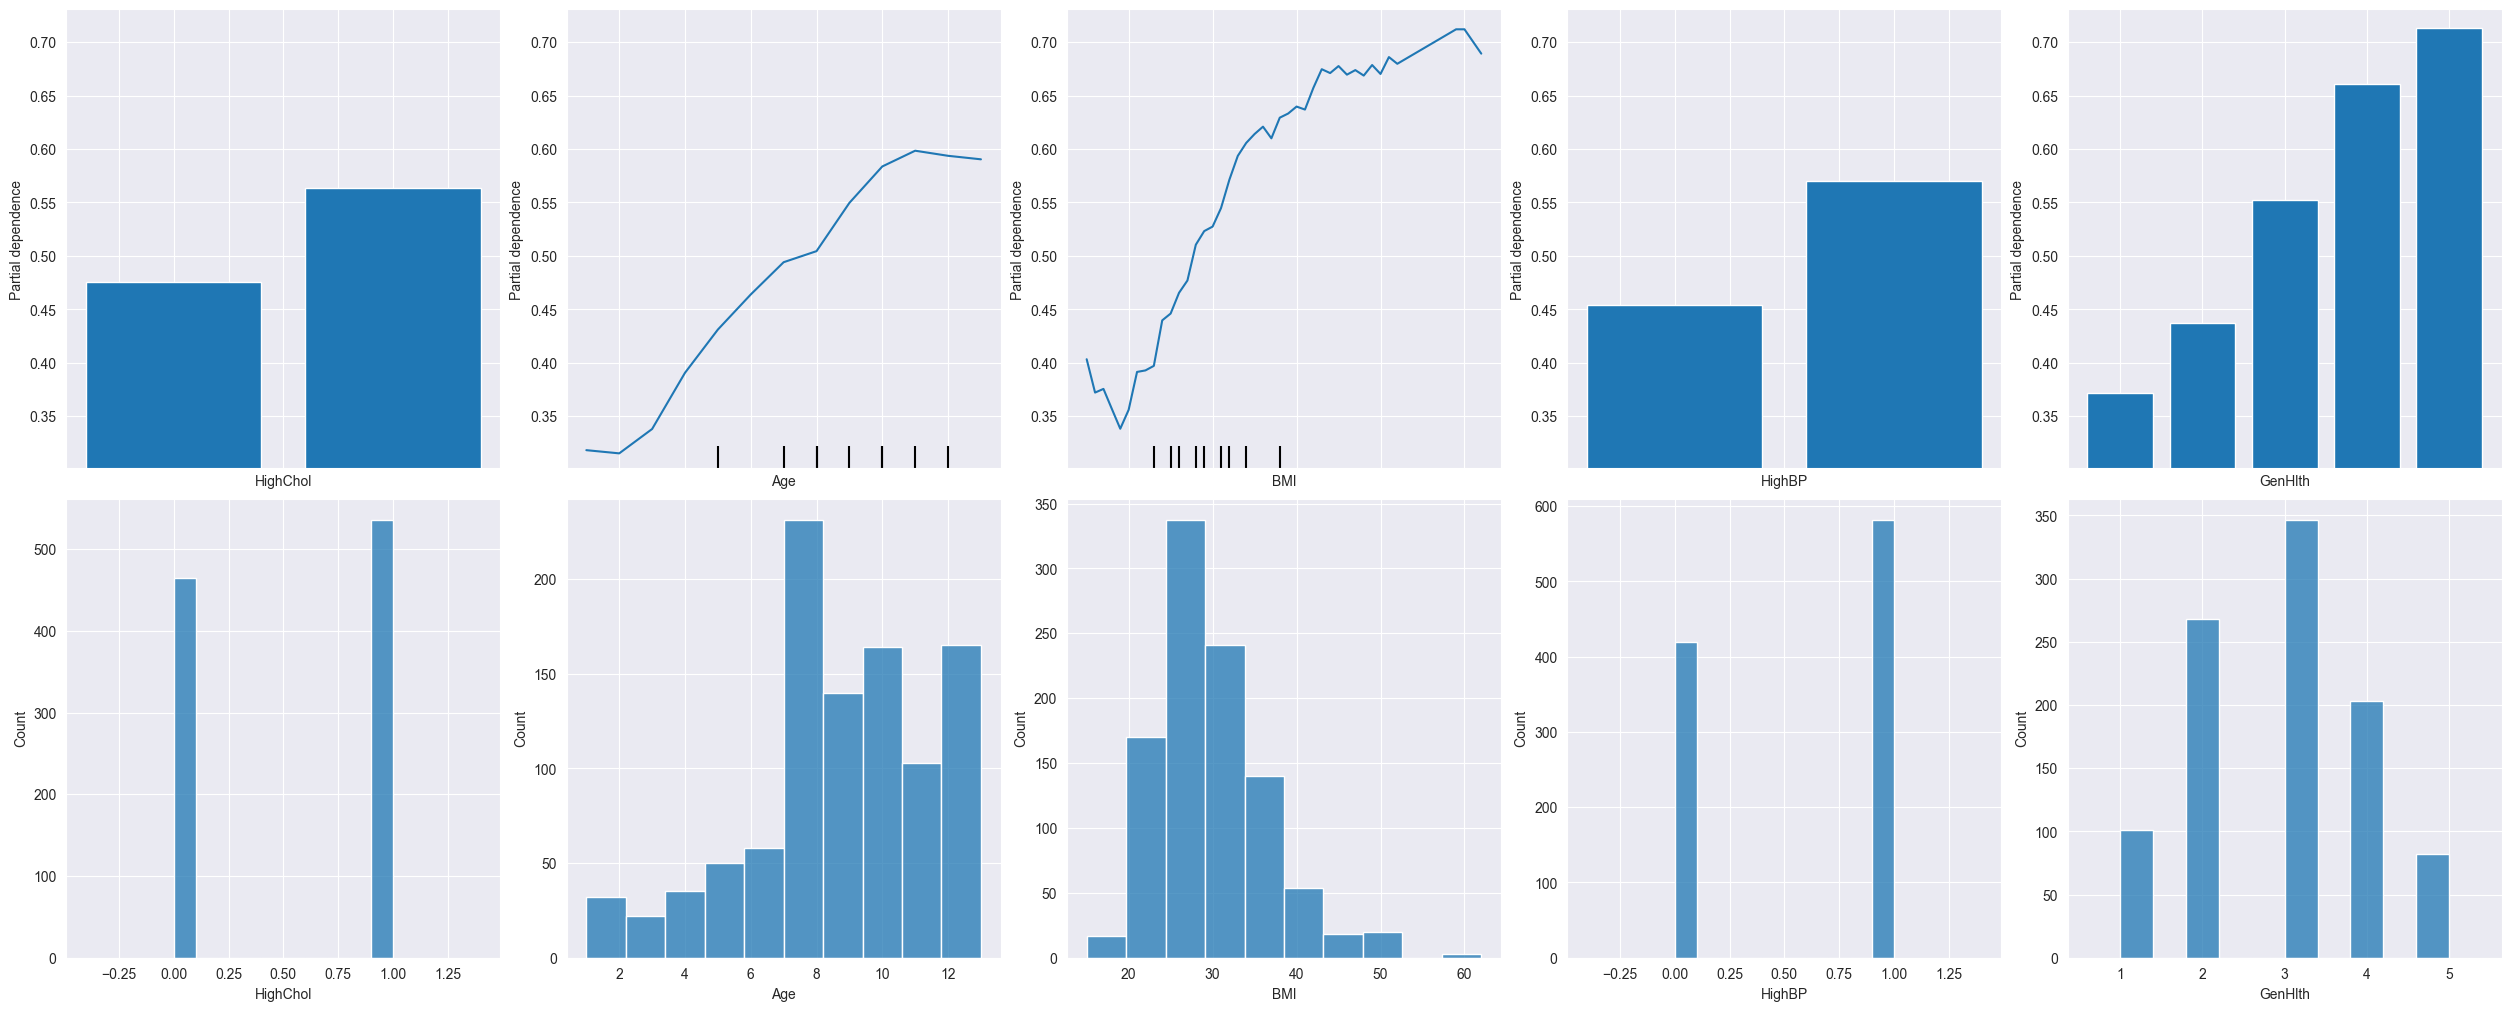

In [44]:
categorical = ["HighChol", "HighBP", "GenHlth"]
best_five = X.columns[indexes]
submuestra = resample(X_test, n_samples=1_000, random_state=0, stratify=y_test)
fig, ax = plt.subplots(
    ncols=5, nrows=2, figsize=(25, 10), constrained_layout=True, sharex="col"
)
display = PartialDependenceDisplay.from_estimator(
    clf, submuestra, best_five, ax=ax[0], categorical_features=categorical
)
for i, feature in enumerate(best_five):
    sns.histplot(
        data=submuestra,
        x=feature,
        ax=ax[1, i],
        multiple="stack",
        bins=10,
    )

¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? R:
 Un punto $(x_j, y)$ en uno de estos gráficos de la característica $j$ indica que que
  el valor promedio de la salida del modelo para instancias con valor $x_j$ en la
  característica $j$ es $y$.

¿Son estas conclusiones generalizables para todo el conjunto de datos? R: Sí, las
interpretaciones obtenidas son globales y nos dan el comportamiento promedio de los
datos. Sin embargo, cabe recordar que los promedios son una medida de tendencia central
 y no nos dan información sobre la dispersión de la dependencia parcial.

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Creando los sistemas de reglas:

In [45]:
explainer = AnchorTabular(
    clf.predict,
    X_train.columns,
    seed=0,
)
explainer.fit(X_train.values)

AnchorTabular(meta={
    'name': 'AnchorTabular',
    'type': ['blackbox'],
    'explanations': ['local'],
    'params': {'seed': 0, 'disc_perc': (25, 50, 75)}
})

In [46]:
indice_instancias = [1000, 3001, 5751]
instancias = X.iloc[indice_instancias, :]
predicciones = explainer.predictor(instancias.values)
nombres = ("No tiene diabetes", "Tiene diabetes")
for indice, instancia, prediccion in zip(
    indice_instancias, instancias.values, predicciones
):
    print(f"Instancia {indice}")
    print("-" * 14)
    print(f"Predicción: {prediccion}")
    explicacion = explainer.explain(instancia)
    print("Regla:", " y ".join(explicacion.anchor))
    print(f"Precisión: {explicacion.precision}")
    print(f"Cobertura: {explicacion.coverage}")
    print(f"Población explicada: {int(explicacion.coverage*len(X))}")
    print()

Instancia 1000
--------------
Predicción: 0
Regla: GenHlth <= 2.00 y HighBP <= 0.00 y Age <= 7.00
Precisión: 0.9958932238193019
Cobertura: 0.3132224304904717
Población explicada: 20052

Instancia 3001
--------------
Predicción: 0
Regla: GenHlth <= 2.00 y HighBP <= 0.00 y Age <= 7.00
Precisión: 0.9924078091106291
Cobertura: 0.3132224304904717
Población explicada: 20052

Instancia 5751
--------------
Predicción: 0
Regla: BMI <= 25.00 y HighBP <= 0.00 y Age <= 7.00
Precisión: 0.9720101781170484
Cobertura: 0.3132224304904717
Población explicada: 20052



¿Tienen sentido sus reglas propuestas para las
observaciones?. Fundamente su respuesta señalando el impacto que tienen sus reglas
sobre todo el conjunto de datos.

R: Se predice que ninguna de las instancias tiene diabetes. En los 3 casos se
utilizaron las reglas que no tuviera alta presión sanguínea y menos de 7 años, que
coincide con lo visto en las partes anteriores, y son reglas que se esperarían. Las
primeras dos instancias además tienen la regla `GenHlth <= 2` (donde ya vimos que
`GenHelth` es monótonamente creciente en probabilidad de diabetes en promedio) y `BMI
 <= 25`, que está en el rango de crecencia visto en los valores de SHAP y PDP.

Todas las reglas tienen altísima precisión, que muestra que son muy localmente
precisas en estas instancias, pero no habla de su generalización. La cobertura es 0.31, es decir, explica poco menos de un tercio de los datos. Esto puede parecer bajo,
 pero si consideramos que es una regla de solamente 3 condiciones para explicar un
 modelo de ensamblaje 100 de árboles de profundidad pequeña (recordando que cada árbol
  es esencialmente un sistema de reglas binarias recursivas, y que sumar árboles es equivalente a reglas
 más complicadas), es una compresión impresionante.

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>